## New Product Adoption with ABM

Agents: 

Customer: comprehensive class considering both psychological motivations and financial possibilities / physical needs of customers

Product: simple class including most important product attributes (does not consider concrete product features)

Brand: simple class for controlling brand strength as it grows when more people adopt the product(s) of this brand 

Market: where the simulation happens


First level analysis: 
- Single random product 
- Completely random traits (Customer)

Second level analysis:
- More logic in the Customer's traits (correlated traits)

Third level analysis: 
- Correlated traits 
- Two competing products 

In [579]:
import numpy as np 
import matplotlib.pyplot as plt 
import networkx as nx
import random
import pandas as pd 
!pip install seaborn
import seaborn as sns

### class Customer, Brand, Product, Market

In [580]:
class Customer:
    def __init__(
        self,
        need: float,
        price_sensitivity: float,
        status_seeking: float,
        dependence_others: float,
        loyalty_tendency: float,
        risk_aversion: float,
        innovation_interest: float,
        brand_customer: bool,
        disposable_income: float,
    ):
        self.need = need
        self.brand_customer = brand_customer
        self.disposable_income = disposable_income

        self.uncertainity = random.uniform(0,1)
        self.price_sensitivity = price_sensitivity
        self.status_seeking = status_seeking
        self.dependence_others = dependence_others
        self.loyalty_tendency = loyalty_tendency
        self.risk_aversion = risk_aversion
        self.innovation_interest = innovation_interest

        self.adopted_products = []
        self.adoption_decision = False
        self.connections = []
    
    def social_pressure(self):
        if not self.connections:
            return 0
        adoption_ratio = sum(1 for c in self.connections if c.adoption_decision) / len(self.connections)
        return adoption_ratio * self.dependence_others
    
    def price_factor(self, product):
        penalty = -product.normalized_price * self.price_sensitivity
        bonus = (product.normalized_price**2) * self.status_seeking
        price_factor = (1-product.luxury_factor) * penalty + product.luxury_factor * bonus
        return price_factor
    
    def relative_price_penalty(self, product):
        if product.competitor_avg_price == 0: 
            return 0 
        relative_price_penalty = -product.relative_price / product.competitor_avg_price * self.price_sensitivity
        return relative_price_penalty
    
    def innovation_bonus(self, product):
        return product.innovation_score * self.innovation_interest
    
    def loyalty_bonus(self, product):
        if self.brand_customer:
            return product.brand_strength * self.loyalty_tendency
        else:
            return 0
     
    def total_bonuses(self, product):
        return -self.risk_aversion + self.innovation_bonus(product) + self.loyalty_bonus(product)
    
    def calculate_score(self, product):
        return (
            self.need
            + self.social_pressure()
            + self.price_factor(product)
            + self.relative_price_penalty(product)
            + self.total_bonuses(product)) 
    
    def calculate_threshold(self):
        base_threshold = 0.8
        curiosity_factor = self.innovation_interest
        risk_factor= self.risk_aversion

        random_adjustment = random.uniform(-0.4, 0.4) + self.uncertainity
        threshold = base_threshold - curiosity_factor + risk_factor + random_adjustment
        return threshold 
    
    def can_afford(self,product):
        return self.disposable_income >= product.price
    
    def make_decision(self, product):
        threshold = self.calculate_threshold()
        if self.can_afford(product):
            score = self.calculate_score(product)
            if score >= threshold:
                self.adoption_decision = True
                self.adopted_products.append(product)
                product.adopted_by.append(self)
                return True 
            else:
                return False 

In [581]:
class Brand:
    def __init__(self, name):
        self.name = name
        self.products = []
        self.brand_strength = 0.0

    def add_product(self, product):
        self.products.append(product)

    def update_brand_strength(self, market):
        market_shares = []
        for product in self.products:
            adoptions = len(product.adopted_by)
            market_share = adoptions / len(market.customers) if market.customers else 0
            market_shares.append(market_share)

        if self.products:
            self.brand_strength = sum(market_shares) / len(self.products)
        else:
            self.brand_strength = 0.0     
        
        for product in self.products:
            product.brand_strength = self.brand_strength

In [582]:
class Product():
    def __init__(self, price, max_price, luxury_factor, innovation_score, competitor_avg_price, brand):
        self.price = price
        self.max_price = max_price
        self.normalized_price = self.price/self.max_price
        self.luxury_factor = luxury_factor
        self.innovation_score = innovation_score
        self.competitor_avg_price = competitor_avg_price
        self.relative_price = self.price- self.competitor_avg_price
        self.adopted_by = []
        self.brand = brand
        self.brand_strength = brand.brand_strength
        
        brand.add_product(self)

In [583]:
class Market():
    def __init__(self):
        self.customers = []
        self.brands = []
        self.products = []
        self.network = None 
    
    def generate_customers(self,customer_factory,n):
        for _ in range(0, n):
            customer = customer_factory()
            self.customers.append(customer)

    def create_network(self):
        n = len(self.customers)
        m = 7

        self.network = nx.barabasi_albert_graph(n, m)

        for i, customer in enumerate(self.customers):
            self.network.nodes[i]['customer'] = customer

        for i, customer in enumerate(self.customers):
            neighbor_indices = list(self.network.neighbors(i))
            customer.connections = [self.network.nodes[n]['customer'] for n in neighbor_indices]
    
        print(f"Created network with {self.network.number_of_nodes()} nodes and {self.network.number_of_edges()} edges")
        print(f"Average number of edges: {self.network.number_of_edges()/self.network.number_of_nodes()}")
        
    def visualize_network(self):
        plt.figure(figsize=(8, 6))
        pos = nx.spring_layout(self.network, seed=42, k=0.15)  # k controls spacing

        nx.draw_networkx_nodes(
            self.network, pos,
            node_size=30,
            node_color="royalblue",
            alpha=0.8
        )

        nx.draw_networkx_edges(
            self.network, pos,
            width=0.2,
            alpha=0.3,
            edge_color="black"
        )

        plt.title("Customer Social Network", fontsize=11)
        plt.axis('off')
        plt.tight_layout(pad=0.5)
        plt.show()

    def release_product(self,product): 
        self.products.append(product)

        for customer in self.customers:
            if customer.innovation_interest >= 0.8: 
                customer.make_decision(product)

    def market_step(self, product, customer): 
        if customer.adoption_decision == False:
            customer.make_decision(product)

### **First-level analysis: Random Market with a Single Random Product**

Outline:
- Random Brand
- Single Random Product 
- Random Customer profile 
- Market with Random Customers
- Release Random Product 

Analysis: 
1. Product features 
2. Customer features
3. Randomness checks 
4. Validity checks 
5. Initial threshold vs. initial score ratio

#### 1. Random Brand

In [584]:
random.seed(1)

# Random Brand
random_name = 'Random_brand'
random_brand = Brand(name=random_name)

#### 2. Random Product

In [585]:
# Random Product attributes
random_price = random.uniform(0,1000)
max_price = 1000
random_luxury_factor = random.uniform(0,1)
random_innovation_score = random.uniform(0,1)
random_competitor_avg_price = random.uniform(0,1000)

random_product = Product(random_price, max_price, random_luxury_factor, random_innovation_score, random_competitor_avg_price,random_brand)

In [586]:
# Product features 
print("Random Product Features")
print("-" * 30)
print(f"Price:                  ${random_product.price:.2f}")
print(f"Max Price:              ${random_product.max_price:.2f}")
print(f"Normalized Price:       {random_product.normalized_price:.2f}")
print(f"Luxury Factor:          {random_product.luxury_factor:.2f}")
print(f"Innovation Score:       {random_product.innovation_score:.2f}")
print(f"Competitor Avg Price:   ${random_product.competitor_avg_price:.2f}")
print(f"Relative Price:         ${random_product.relative_price:.2f}")
print(f"Brand Strength:         {random_product.brand_strength:.2f}")
print(f"Brand Name:             {random_product.brand.name}")

Random Product Features
------------------------------
Price:                  $134.36
Max Price:              $1000.00
Normalized Price:       0.13
Luxury Factor:          0.85
Innovation Score:       0.76
Competitor Avg Price:   $255.07
Relative Price:         $-120.70
Brand Strength:         0.00
Brand Name:             Random_brand


#### 3. Random Customer profile

In [587]:
# Random Customer factory

def random_customer():
    customer = Customer(
        need=random.uniform(0,1),
        price_sensitivity=random.uniform(0,1),
        status_seeking=random.uniform(0,1),
        dependence_others=random.uniform(0,1),
        loyalty_tendency=random.uniform(0,1),
        risk_aversion=random.uniform(0,1),
        innovation_interest=random.uniform(0,1),
        brand_customer=random.choice([0,1]),
        disposable_income=random.uniform(0,1000))
    return customer 

#### 4. Random Market

##### a) Random Market - generating customers

In [588]:
# Random market - generate customers 

random_market = Market()
random_market.generate_customers(random_customer,n=1000)
random_customers = random_market.customers

##### Customer profile analysis 

1. Customer features 
2. Randomness and uniformity checks 
3. Initial threshold vs. score ratio

In [589]:
def extract_customer_data(customers):
    data = {
        "need": [c.need for c in customers],
        "price_sensitivity": [c.price_sensitivity for c in customers],
        "status_seeking": [c.status_seeking for c in customers],
        "dependence_others": [c.dependence_others for c in customers],
        "loyalty_tendency": [c.loyalty_tendency for c in customers],
        "risk_aversion": [c.risk_aversion for c in customers],
        "innovation_interest": [c.innovation_interest for c in customers],
        "brand_customer": [c.brand_customer for c in customers],
        "disposable_income": [c.disposable_income for c in customers],
        "threshold": [c.calculate_threshold() for c in customers],
        "initial_adoption": [c.adoption_decision for c in customers],
    }
    return pd.DataFrame(data)

df = extract_customer_data(random_customers)

df.head()

,need,price_sensitivity,status_seeking,dependence_others,loyalty_tendency,risk_aversion,innovation_interest,brand_customer,disposable_income,threshold,initial_adoption
0,0.495435,0.449491,0.651593,0.788723,0.093860,0.028347,0.835765,1,607.437996,1.063841,False
1,0.695833,0.266331,0.801826,0.591153,0.102227,0.317430,0.022322,0,939.149163,1.184901,False
2,0.216599,0.422117,0.029041,0.221692,0.437888,0.495812,0.233084,0,676.848540,1.539678,False
3,0.952244,0.926507,0.416180,0.916270,0.922189,0.100000,0.629353,1,120.889960,0.305479,False
4,0.721484,0.711192,0.936441,0.422107,0.830036,0.670306,0.303369,1,846.197418,2.018804,False


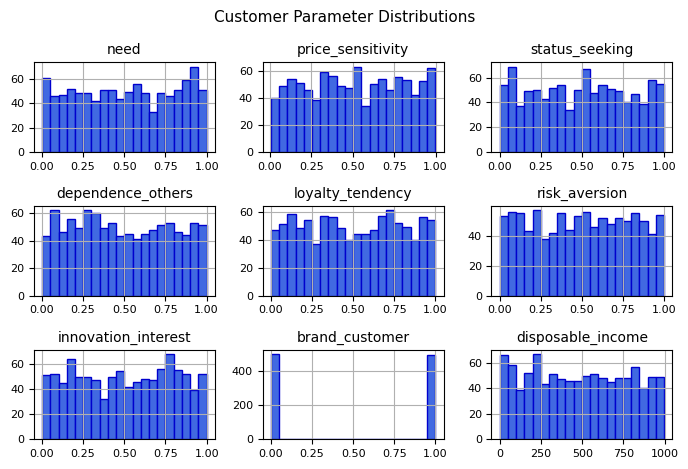

In [590]:
df.drop(columns=["threshold", "initial_adoption"]).hist(bins=20, figsize=(7, 6), layout=(4, 3), color="royalblue", edgecolor="mediumblue")
plt.suptitle("Customer Parameter Distributions", fontsize=11)
plt.tight_layout()
plt.show()

Comment: The parameters fall correctly into the random uniform distributions.

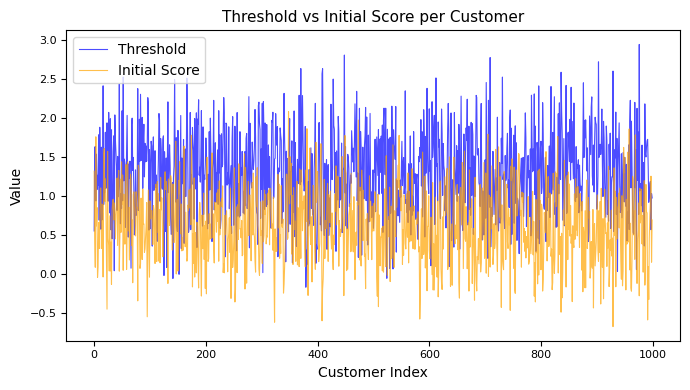

In [591]:
thresholds = [c.calculate_threshold() for c in random_market.customers]
initial_scores = [c.calculate_score(random_product) for c in random_market.customers]

plt.figure(figsize=(7, 4))
plt.plot(thresholds, label="Threshold", color="blue", alpha=0.7, linewidth=0.8)  
plt.plot(initial_scores, label="Initial Score", color="orange", alpha=0.7, linewidth=0.8)  
plt.xlabel("Customer Index")
plt.ylabel("Value")
plt.title("Threshold vs Initial Score per Customer", fontsize=11)
plt.legend()
plt.tight_layout()
plt.show()

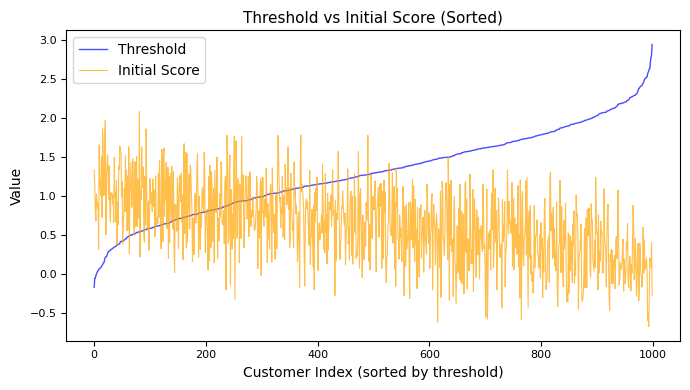

In [592]:
sorted_data = sorted(zip(thresholds, initial_scores), key=lambda x: x[0])
sorted_thresholds, sorted_scores = zip(*sorted_data)
plt.figure(figsize=(7, 4))
plt.plot(sorted_thresholds, label="Threshold", color="blue", alpha=0.7, linewidth=1)
plt.plot(sorted_scores, label="Initial Score", color="orange", alpha=0.7, linewidth = 0.8)
plt.xlabel("Customer Index (sorted by threshold)")
plt.ylabel("Value")
plt.title("Threshold vs Initial Score (Sorted)", fontsize=11)
plt.legend()
plt.tight_layout()
plt.show()

**Comment:** 

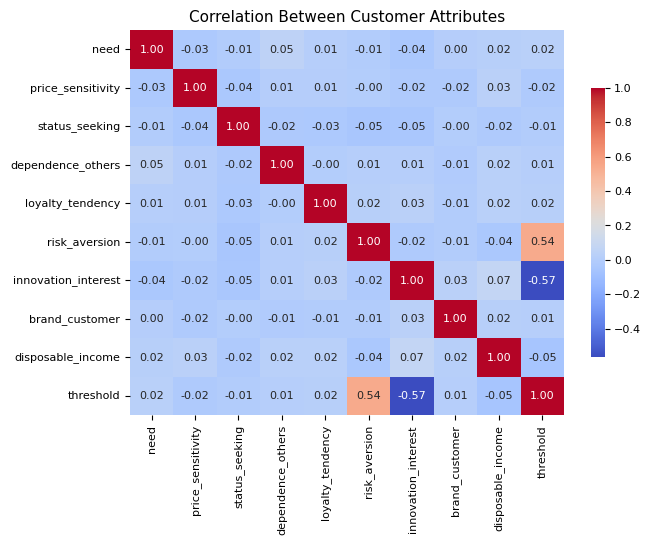

In [593]:
plt.figure(figsize=(7, 5))
corr = df.drop(columns=["initial_adoption"]).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=False, annot_kws={"size":8}, cbar_kws={"shrink":0.7})
plt.title("Correlation Between Customer Attributes", fontsize=11)
plt.show()

**Comment:** The matrix the relationships between all Customer parameters. As can be observed in the matrix, Customer attributes ae generally not correlated with each other, which provides solid validity support for their random generation.  

As expected, both risk_aversion and innovation_interest are moderately correlated with the feature threshold, since these parameters are explicitly used to calculate the threshold feature.

##### b) Random Market - creating a network

In [594]:
random_market.create_network()
random_network = random_market.network

Created network with 1000 nodes and 6951 edges
Average number of edges: 6.951


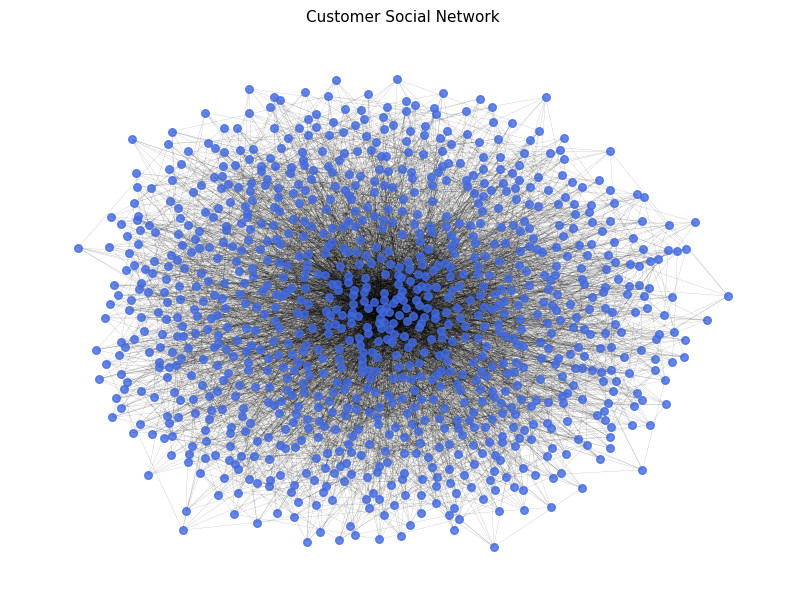

In [595]:
random_market.visualize_network()